## Train the model

In [7]:
import tensorflow as tf
from keras import models, layers, optimizers
import os
import math

# Setup
train_dir = '../../data/processed/resize/train'  
val_dir = '../../data/processed/resize/validation'  

Sequential = models.Sequential
Conv2D = layers.Conv2D
MaxPooling2D = layers.MaxPooling2D
Flatten = layers.Flatten
Dense = layers.Dense
Dropout = layers.Dropout
Input = layers.Input
Adam = optimizers.Adam
ImageDataGenerator = tf.keras.preprocessing.image.ImageDataGenerator

# Normalize dataset
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)  

# Create dataset
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  # Image size
    batch_size=32,          # Images per batch
    class_mode='categorical' # Multi-class classification
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical' # Multi-class classification
)

# Define the model
model = Sequential([
    Input(shape=(150, 150, 3)),
    Conv2D(32, (3, 3), padding="same", activation='relu'),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(64, (3, 3), padding="same", activation='relu'),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(128, (3, 3), padding="same", activation='relu'),
    MaxPooling2D(pool_size=(3, 3)),
    Flatten(),                                # Convert to 1D
    Dense(512, activation='relu'),            # Fully Connected Layer
    Dropout(0.2),                             # Reduce Overfitting
    Dense(128, activation='relu'),
    Dropout(0.2),                             
    Dense(train_generator.num_classes, activation='softmax'),  # Output layer for multi-class
])

model.compile(
    loss='categorical_crossentropy',  # Loss function for multi-class classification
    optimizer=Adam(learning_rate=0.001),  # Optimizer
    metrics=['accuracy']  # Metrics
)

# Calculate steps per epoch and validation steps
steps_per_epoch = math.ceil(train_generator.samples / train_generator.batch_size)
validation_steps = math.ceil(val_generator.samples / val_generator.batch_size)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=val_generator,
    validation_steps=validation_steps,
)

# Save the model
model.save('../../models/multi_class_classifier.keras')


Found 9724 images belonging to 6 classes.
Found 2434 images belonging to 6 classes.
Epoch 1/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 58s 186ms/step - accuracy: 0.8116 - loss: 0.5903 - val_accuracy: 0.9297 - val_loss: 0.1935
Epoch 2/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 44s 144ms/step - accuracy: 0.9410 - loss: 0.1837 - val_accuracy: 0.9511 - val_loss: 0.1447
Epoch 3/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 44s 144ms/step - accuracy: 0.9517 - loss: 0.1397 - val_accuracy: 0.9552 - val_loss: 0.1432
Epoch 4/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 44s 145ms/step - accuracy: 0.9578 - loss: 0.1280 - val_accuracy: 0.9482 - val_loss: 0.1575
Epoch 5/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 44s 145ms/step - accuracy: 0.9648 - loss: 0.1062 - val_accuracy: 0.9507 - val_loss: 0.1453
Epoch 6/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 44s 144ms/step - accuracy: 0.9634 - loss: 0.1277 - val_accuracy: 0.9552 - val_loss: 0.1364
Epoch 7/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 44s 145ms/step - accuracy: 0.9741 - loss: 0.0783 - val_accuracy: 0.9601 - val_loss: 0.1362

## Test trained model

Found 2430 images belonging to 6 classes.
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step
              precision    recall  f1-score   support

       apple       1.00      0.99      1.00      1624
     cabbage       1.00      0.80      0.89        44
      carrot       0.92      0.88      0.90       138
    cucumber       0.81      0.97      0.89       316
    eggplant       0.97      0.88      0.92        67
        pear       0.96      0.80      0.88       241

    accuracy                           0.96      2430
   macro avg       0.94      0.89      0.91      2430
weighted avg       0.96      0.96      0.96      2430



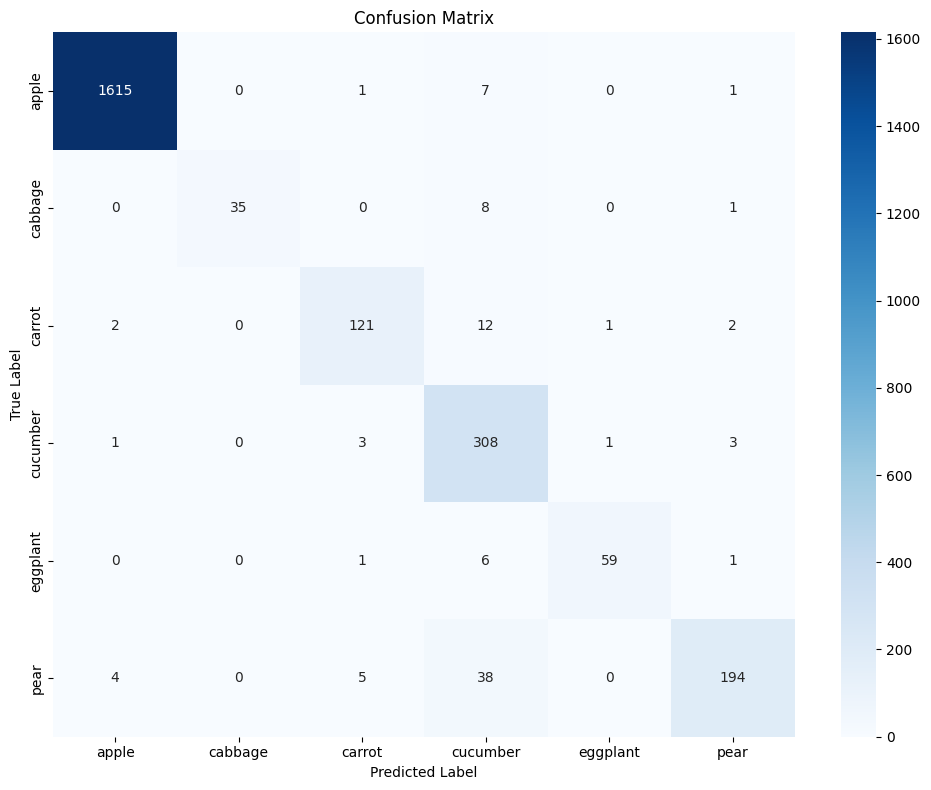

In [8]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# Load the saved model
model = tf.keras.models.load_model('../../models/multi_class_classifier.keras')  # Update model path
data_path = '../../data/processed/resize/test'  # Path to test dataset

# Prepare new data generator
new_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)
new_generator = new_datagen.flow_from_directory(
    data_path,  # Directory containing subdirectories for each class
    target_size=(150, 150),  # Match the model's input size
    batch_size=32,
    class_mode='categorical',  # Use 'categorical' for multi-class tasks
    shuffle=False  # Ensure order consistency for evaluation
)

# Predict
predictions = model.predict(new_generator)
predicted_classes = np.argmax(predictions, axis=1)  # Get class indices for the highest probability

# Get true labels
true_labels = new_generator.classes

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=new_generator.class_indices.keys(), 
            yticklabels=new_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig('confusion_matrix_multi_class.png')

# Print classification report
print(classification_report(true_labels, predicted_classes, 
                             target_names=list(new_generator.class_indices.keys())))
